In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

idx = pd.IndexSlice

In [3]:
fn = str(Path.cwd().parent / 'summaries' / 'total_summary_{}.csv').format('flex')

c = pd.read_csv(
    fn,
    index_col=[0,1],
    parse_dates=True
).loc[idx[:,'congestion_rent'], 'zonal']


c = c.groupby(c.index.get_level_values(0).strftime('%Y-%m-%d')).sum()

C:\Users\lukas\AppData\Local\Temp\ipykernel_23180\1453767975.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  c = pd.read_csv(


In [4]:
fn = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_flex_{}.csv')

r_zonal = pd.read_csv(
    fn.format('zonal'),
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)

r_national = pd.read_csv(
    fn.format('national'),
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)

In [5]:
r_zonal.columns.get_level_values(1).unique()

Index(['wind', 'disp', 'water', 'intercon', 'load'], dtype='object')

In [58]:
def prep_rev(df):

    idx = pd.IndexSlice

    df = df.copy()
    # df = df.loc[:, idx[:,['wind','disp','water'], ['wholesale', 'cfd']]]
    df = df.loc[:, idx[:,['wind','disp','water'], ['wholesale']]]

    return df.groupby(df.index.strftime('%Y-%m-%d')).sum()


zon = prep_rev(r_zonal)
nat = prep_rev(r_national)

In [59]:
diff = (zon - nat).sum(axis=1).mul(1e-6)

In [60]:
plo = pd.concat((diff, c.mul(-1)), axis=1).rename(columns={
    0: 'lost_revenue',
    'zonal': 'congestion_rent',
}).sort_values('congestion_rent', ascending=False)

plo

,lost_revenue,congestion_rent
2022-03-08,-2.471814e+01,34.676233
2022-03-09,-3.867896e+01,32.310278
2022-08-18,-2.641308e+01,31.813850
2022-09-05,-2.359255e+01,28.981187
2022-09-03,-1.150396e+01,28.819984
...,...,...
2023-12-01,1.041405e-11,-0.000000
2023-11-30,-1.576496e-12,-0.000000
2023-06-14,-1.282245e-11,-0.000000
2023-06-13,-1.091138e-11,-0.000000


In [61]:
plo.head(2)

,lost_revenue,congestion_rent
2022-03-08,-24.718143,34.676233
2022-03-09,-38.678962,32.310278


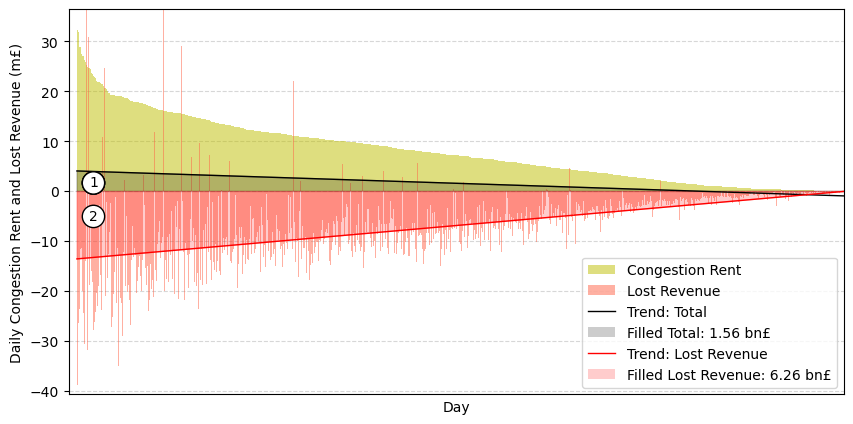

In [62]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x = np.arange(len(plo))

for i, (day, row) in enumerate(plo.iterrows()):
    ax.bar(i, width=1, bottom=0, height=row.congestion_rent, alpha=0.5, color='y')
    ax.bar(i, width=1, bottom=0, height=row.lost_revenue, alpha=0.5, color='tomato')

# Prepare data for linear regression using sklearn
X = x.reshape(-1, 1)
y_total = (plo['congestion_rent'] + plo['lost_revenue']).values
y_lost = plo['lost_revenue'].values

# Linear regression for total (congestion_rent + lost_revenue)
model_total = LinearRegression()
model_total.fit(X, y_total)
pred_total = model_total.predict(X)

# Linear regression for lost revenue
model_lost = LinearRegression()
model_lost.fit(X, y_lost)
pred_lost = model_lost.predict(X)

# Plot the regression lines
ax.plot(x, pred_total, color='k', linewidth=1)
ax.fill_between(x, np.clip(pred_total, 0, None), color='k', alpha=0.2)
ax.plot(x, pred_lost, color='r', linewidth=1)
ax.fill_between(x, np.minimum(pred_lost, 0), color='r', alpha=0.2)


ax.set_ylabel('Daily Congestion Rent and Lost Revenue (m£)')
ax.set_ylim(plo['lost_revenue'].min() * 1.05, plo['congestion_rent'].max() * 1.05)

ax.set_xticks([])
ax.set_xlabel('Day')

margin = 10
positive_idx = np.where(pred_lost > 0)[0][0]

#  if positive_idx.size > 0:
#   upper_limit = positive_idx[-1] + margin
# else:
#     upper_limit = len(plo) + margin

ax.set_xlim(-margin, positive_idx)

ax.grid(True, linestyle='--', alpha=0.5, axis='y')
ax.set_axisbelow(True)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
filled_total_bn = np.clip(pred_total, 0, None).sum() / 1000.0
filled_lost_bn = abs(np.minimum(pred_lost, 0).sum()) / 1000.0

handles = [
    Patch(facecolor='y', alpha=0.5, label='Congestion Rent'),
    Patch(facecolor='tomato', alpha=0.5, label='Lost Revenue'),
    Line2D([0], [0], color='k', lw=1, label='Trend: Total'),
    Patch(facecolor='k', alpha=0.2, label=f'Filled Total: {filled_total_bn:.2f} bn£'),
    Line2D([0], [0], color='r', lw=1, label='Trend: Lost Revenue'),
    Patch(facecolor='r', alpha=0.2, label=f'Filled Lost Revenue: {filled_lost_bn:.2f} bn£')
]

ax.legend(handles=handles, loc='lower right')

def add_number(num, x, y):
    """
    Adds a text 'num' to the current plot at the position (x, y) with a circle around it.
    """
    ax = plt.gca()  # Get the current axes
    ax.text(
        x, y, str(num),
        ha='center', va='center',
        bbox=dict(
            boxstyle='circle',
            edgecolor='black',
            facecolor='w',
            linewidth=1
        )
    )


add_number(1, 20, 1.7)
add_number(2, 20, -5)

plt.show()

In [36]:
print(ax.get_xlim())

(-10.0, 1087.0)


In [35]:
(plo['lost_revenue'] + plo['congestion_rent']).sum()


1296.014387448101